## Fixed point iteration (and Newton's method)

In [1]:
# the required imports
import numpy as np
from scipy.linalg import lu, solve_triangular
from numpy.linalg import qr, svd, inv
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
from ipywidgets import interactive, IntSlider, FloatSlider, fixed

_setup some helper functions_

In [2]:
# helper function to load Shepp-Logan phantom 
def getPhantom(size):
    if size == 128:
        return plt.imread('phantom.png')
    elif size == 32:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/4, mode='reflect', multichannel=False)
    elif size == 4:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/32, mode='reflect', multichannel=False)
    else:
        raise NotImplementedError


# compute the matrix of the Radon transform (and also do the right hand side)
def computeRadonMatrixRhs(image, numberOfAngles):
    angles = np.linspace(0, 180, numberOfAngles) 
    
    sizeX, sizeY = image.shape
    if sizeX != sizeY:                   # this works only for square images!
        raise ValueError
    size = image.size
    
    M = np.zeros((angles.size * sizeX, size)) # initialize matrix with zeros
    basisVec = np.zeros(size)            # initialize basis vector with zeros
    
    for i in range(size):
        basisVec[i] = 1                                # set to i-th basis vector
        bVecAsImg = basisVec.reshape(sizeX, sizeY)     # reshape to a 2d image
        
        column = radon(bVecAsImg, angles, circle=True) # compute Radon transform of this basis vector
        M[:, i] = column.flatten()                     # linearize and put into matrix as i-th column
        
        basisVec[i] = 0                                # reset basis vector to zero
        
    rhs = radon(image, angles, circle=True) # compute the right hand side
    return (M, rhs.flatten())

### Setup our matrix (and right-hand side)

A has size =  (1024, 1024) , and b has size =  1024


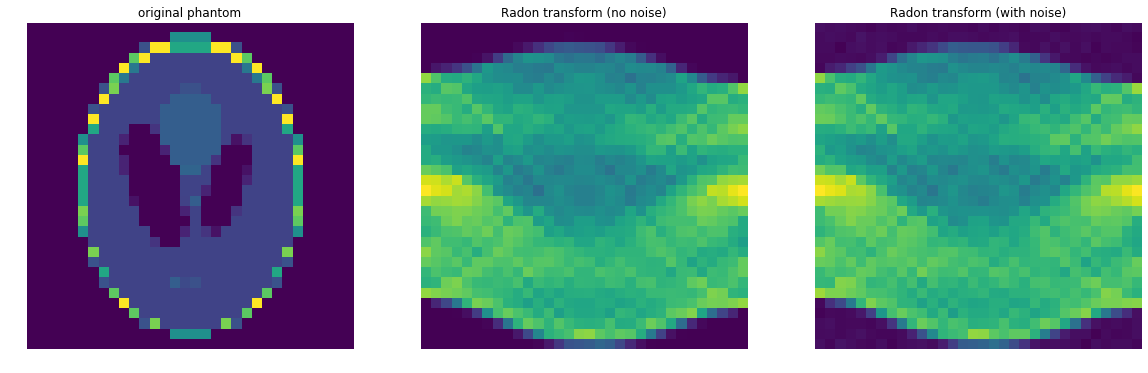

In [8]:
image = getPhantom(32)

plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1, title='original phantom')
plt.imshow(image); plt.axis('off')

# get matrix A and no-noise right-hand-side b
A, b = computeRadonMatrixRhs(image, 32)
print("A has size = ", A.shape, ", and b has size = ", b.size)

# precompute A^TA and pinv(A^TA)
AtA = np.dot(A.T, A)
pinvAtA = np.linalg.pinv(AtA)

# add some white noise to right-hand-side b
noise = max(b) * 0.01 * np.random.randn(b.size)
bNoisy = b + noise

plt.subplot(1, 3, 2, title='Radon transform (no noise)')
plt.imshow( b.reshape(32, 32) ); plt.axis('off')

plt.subplot(1, 3, 3, title='Radon transform (with noise)')
plt.imshow( bNoisy.reshape(32, 32) ); plt.axis('off')
plt.show()

### Setup fixed point iteration

In [42]:
# setup the functions we are going to iterate

def fixFuncGeneric(x, rhs):
    Fx = AtA.dot(x) - (A.T).dot(rhs)
    return x - Fx

def fixFuncNewton(x, rhs):
    Fx = AtA.dot(x) - (A.T).dot(rhs)
    JFx = AtA
    pinvJFx = pinvAtA
    return x - np.dot(pinvJFx, Fx)

In [43]:
# function to perform fixed point iteration
def fixedPointIteration(function, iterations, startingValue, rhs):
    x = startingValue
    for i in range(iterations):
        Tx = function(x, rhs)
        x = Tx
    
    return x

### Solve the reconstruction problem using fixed point iteration

In [44]:
def computeSolutions(iterations, withNoise):
    # set right hand side
    if (withNoise):
        rhs = bNoisy
    else:
        rhs = b
    
    # 0 vector as starting value
    startingValue = np.zeros((32, 32))

    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1, title='Fixed point iteration')
    plt.imshow(fixedPointIteration(fixFuncGeneric, iterations, startingValue.flatten(), rhs).reshape(32, 32)); plt.axis('off')

    plt.subplot(1, 2, 2, title='Newton iteration')
    plt.imshow(fixedPointIteration(fixFuncNewton, iterations, startingValue.flatten(), rhs).reshape(32, 32)); plt.axis('off')
    plt.show()

In [45]:
iplot = interactive(computeSolutions, withNoise=fixed(False),
                   iterations=IntSlider(min=1, max=150, step=1, value=10, continuous_update=False))
iplot

interactive(children=(IntSlider(value=10, continuous_update=False, description='iterations', max=150, min=1), …

### now with noise

In [46]:
iplot = interactive(computeSolutions, withNoise=fixed(True),
                   iterations=IntSlider(min=1, max=150, step=1, value=10, continuous_update=False))
iplot

interactive(children=(IntSlider(value=10, continuous_update=False, description='iterations', max=150, min=1), …

### how about some Tikhonov regularization?

In [37]:
# setup the functions we are going to iterate

def fixFuncGenericTikhonov(x, rhs, alpha):
    Fx = AtA.dot(x) + alpha*x - (A.T).dot(rhs)
    return x - Fx

def fixFuncNewtonTikhonov(x, rhs, alpha):
    Fx = AtA.dot(x) + alpha*x - (A.T).dot(rhs)
    JFx = AtA + alpha*np.eye(b.size)
    pinvJFx = np.linalg.pinv(JFx)
    return x - np.dot(pinvJFx, Fx)

In [47]:
# function to perform fixed point iteration
def fixedPointIterationTikhonov(function, iterations, startingValue, rhs, alpha):
    x = startingValue
    for i in range(iterations):
        Tx = function(x, rhs, alpha)
        x = Tx
    
    return x

In [48]:
def computeSolutionsTikhonov(iterations, alpha, withNoise):
    # set right hand side
    if (withNoise):
        rhs = bNoisy
    else:
        rhs = b
    
    # 0 vector as starting value
    startingValue = np.zeros((32, 32))

    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1, title='Fixed point iteration')
    plt.imshow(fixedPointIterationTikhonov(fixFuncGenericTikhonov, iterations, startingValue.flatten(), rhs, alpha).reshape(32, 32)); plt.axis('off')

    plt.subplot(1, 2, 2, title='Newton iteration')
    plt.imshow(fixedPointIterationTikhonov(fixFuncNewtonTikhonov, iterations, startingValue.flatten(), rhs, alpha).reshape(32, 32)); plt.axis('off')
    plt.show()

In [50]:
iplot = interactive(computeSolutionsTikhonov, withNoise=fixed(True),
                   iterations=IntSlider(min=1, max=150, step=1, value=1, continuous_update=False),
                   alpha=FloatSlider(minx=0, max=100, step=0.1, value=0.1, continuous_update=False))
iplot

interactive(children=(IntSlider(value=1, continuous_update=False, description='iterations', max=150, min=1), F…